# Novel rankings, by raw alignment counts

So, to start - which novels are quoted most frequently? We can get a simple set of this just by counting up the total number of matches of 5+ significant tokens for each novel:

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sqlalchemy import func

from quotes.models import ChadhNovel, BPOArticle, Alignment
from quotes.services import session

In [3]:
count = func.count(Alignment.a_id)

alignment_counts = (
    session
    .query(ChadhNovel.slug, count)
    .join(Alignment, BPOArticle)
    .filter(
        Alignment.size >= 5,
        BPOArticle.object_type == 'Review'
    )
    .group_by(ChadhNovel.slug)
    .order_by(count.desc())
)

In [4]:
for slug, count in alignment_counts:
    print(slug, count)

Chadwyck_British_1819_Scott_IvanhoeARomance 2008
Chadwyck_British_1817_Scott_RobRoyin 1148
Chadwyck_British_1814_Scott_WaverleyorTis 1076
Chadwyck_British_1821_Scott_Kenilworthinthe 992
Chadwyck_British_1816_Scott_OldMortalityin 937
Chadwyck_British_1819_Scott_TheBrideof 784
Chadwyck_British_1823_Scott_QuentinDurwardin 775
Chadwyck_British_1847_Disraeli_TancredorThe 673
Chadwyck_British_1850_Kingsley_AltonLockeTailor 646
Chadwyck_British_1815_Scott_TheAntiquaryin 597
Chadwyck_British_1853_Bronte_VilletteByCurrer 525
Chadwyck_British_1851_Borrow_LavengrotheScholar 519
Chadwyck_British_1849_Bronte_ShirleyATale 498
Chadwyck_British_1837_Dickens_ThePosthumousPapers 494
Chadwyck_British_1839_Taylor_ConfessionsOfA 492
Chadwyck_British_1809_More_CoelebsinSearch 488
Chadwyck_British_1824_Scott_Redgauntletinthe 488
Chadwyck_British_1849_Thackeray_TheHistoryof 458
Chadwyck_British_1844_Disraeli_ConingsbyorThe 441
Chadwyck_British_1872_Eliot_MiddlemarchAStudy 430
Chadwyck_British_1863_Oliphant_Sa

# Alignment size distribution

But, two problems with this. First, we're ignoring the size of the alignment match - we're treating a 5-word match the same as a 50-word match, of which there are actually quite a few. Here's the falloff in the alignment sizes, on log scale:

In [5]:
from collections import OrderedDict

size_counts = OrderedDict(
    session
    .query(Alignment.size, func.count(Alignment.a_id))
    .filter(Alignment.size >= 5)
    .group_by(Alignment.size)
    .order_by(Alignment.size.desc())
    .all()
)

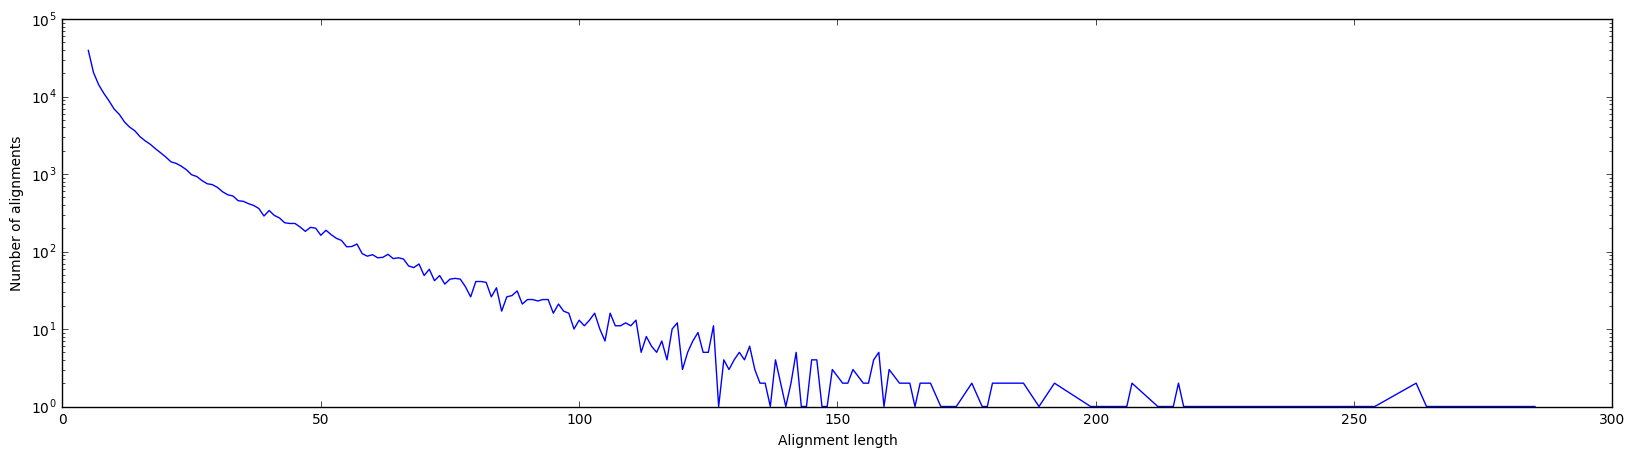

In [6]:
plt.figure(figsize=(20, 5))
plt.xlabel('Alignment length')
plt.ylabel('Number of alignments')
plt.yscale('log')

plt.plot(
    list(size_counts.keys()),
    list(size_counts.values()),
)

plt.show()

# Total BPO article length by year

Second, beause the BPO corpus distributes unevenly across historical time, we need to take into account the total quantity of text in the BPO corpus in the 10 years after the publication of the novel. Eg, if there are 10k articles in the decade after the publication of novel X, but just 1k in the decade after novel Y, novel X has 10x as many opportunities to get quoted. Here's the historical distribution of BPO:

In [7]:
from joblib import Memory

from quotes.models import BPOArticle

mem = Memory('cache')

bpo_year_lens = mem.cache(BPOArticle.year_lengths)()

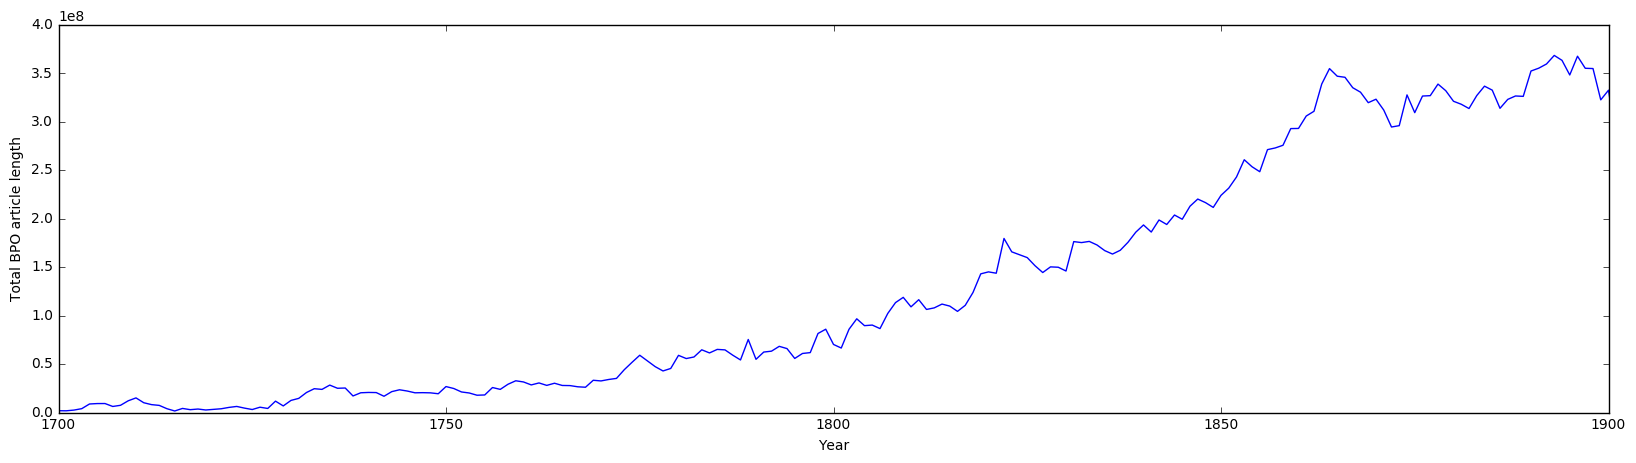

In [8]:
plt.figure(figsize=(20, 5))
plt.xlabel('Year')
plt.ylabel('Total BPO article length')
plt.xlim(1700, 1900)

plt.plot(
    list(bpo_year_lens.keys()),
    list(bpo_year_lens.values()),
)

plt.show()

# Adjusted novel rankings

So, to get a good ranking, we need to take the ratio between the total size of all incoming quotations onto each novel - taking into account the length of each individual quote - and the total length of all the BPO articles in the decade after the novel was published. Ivanhoe still wins, but, if you look at the `alignment_count` column (used by the first ranking), there are some cases where this is moving things up and down in the stack:

In [9]:
data = []
for novel in ChadhNovel.query.all():

    bpo_len = 0
    for year in range(novel.year, novel.year+11):
        bpo_len += bpo_year_lens[year]
        
    alignment_len = (
        session
        .query(func.sum(Alignment.size))
        .join(BPOArticle)
        .filter(
            Alignment.a_id == novel.id,
            Alignment.size >= 5,
            BPOArticle.object_type == 'Review',
        )
        .scalar()
    )
       
    alignment_count = (
        session
        .query(func.count(Alignment.a_id))
        .join(BPOArticle)
        .filter(
            Alignment.a_id == novel.id,
            Alignment.size >= 5,
            BPOArticle.object_type == 'Review',
        )
        .scalar()
    )
    
    if alignment_len:
        
        score = alignment_len / bpo_len
        
        data.append((
            novel.slug,
            alignment_count,
            alignment_len,
            bpo_len,
            score,
        ))

In [10]:
import pandas as pd

df = pd.DataFrame(data, columns=(
    'slug',
    'alignment_count',
    'alignment_len',
    'bpo_len',
    'score',
))

df.sort_values('score', ascending=False, inplace=True)

In [11]:
pd.set_option('display.max_rows', 1000)

df.head(500)

,slug,alignment_count,alignment_len,bpo_len,score
51,Chadwyck_British_1819_Scott_IvanhoeARomance,2008,20186,1696616942,1.189779e-05
37,Chadwyck_British_1814_Scott_WaverleyorTis,1076,11964,1501130079,7.969996e-06
43,Chadwyck_British_1817_Scott_RobRoyin,1148,11421,1630875627,7.002987e-06
41,Chadwyck_British_1816_Scott_OldMortalityin,937,9886,1590782078,6.214553e-06
55,Chadwyck_British_1821_Scott_Kenilworthinthe,992,9511,1730798374,5.495152e-06
52,Chadwyck_British_1819_Scott_TheBrideof,784,7738,1696616942,4.560841e-06
58,Chadwyck_British_1823_Scott_QuentinDurwardin,775,7210,1759359808,4.098082e-06
27,Chadwyck_British_1809_More_CoelebsinSearch,488,5153,1262547661,4.081430e-06
39,Chadwyck_British_1815_Scott_TheAntiquaryin,597,5666,1549096923,3.657615e-06
92,Chadwyck_British_1847_Disraeli_TancredorThe,673,8812,2655132893,3.318855e-06
